In [10]:
# import tools
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft, fftfreq
import scipy
import plotly.graph_objects as go


In [28]:
# Define some useful constants

# how many samples to cut out of the frequency transitions
# - guessing at this based on reference scripts and int() because it can't be a float for indexing
gate = int(200e3)

# sample rate of the measurements
sampleRate = 2e6

# some things for plotting
nSamples = int(3*20e6)
t = np.linspace(0,30,nSamples)

# things for filtering
nyq = .5 * sampleRate
refCtrFreq = 98.5e6
band = .3e6
lwr = 0 - band; upr = 0 + band
bandPass = [lwr / nyq, upr / nyq]

In [4]:
# import the binary files
rawData_benGS = np.fromfile(
    "/Users/benjaminpattison/Documents/Projects/satNav/SDR_satellite_tracking/data/test5_benGS.dat",
    dtype="uint8",
)
rawData_domGS = np.fromfile(
    "/Users/benjaminpattison/Documents/Projects/satNav/SDR_satellite_tracking/data/test5_domGS.dat",
    dtype="uint8",
)

# subtract 255/2 to go from unsigned to signed values
benData = rawData_benGS - 127.5
domData = rawData_domGS - 127.5

# split the data into its real and imaginary parts
benRealParts = benData[0::2]
benImagParts = benData[1::2]
domRealParts = domData[0::2]
domImagParts = domData[1::2]

# create a variable that has the real and imaginary parts together
benCplx = benRealParts + 1j * benImagParts
domCplx = domRealParts + 1j * domImagParts


In [5]:
# Define somethings for slicing the data into parts
# number of samples for each frequency
ben_nS = np.size(benCplx, 0)
dom_nS = np.size(domCplx, 0)
if ben_nS != dom_nS:
    print("You don't have the same number of samples from each ground station")
    exit()
else:
    nS_total = dom_nS
    nS_each = int(nS_total / 3)


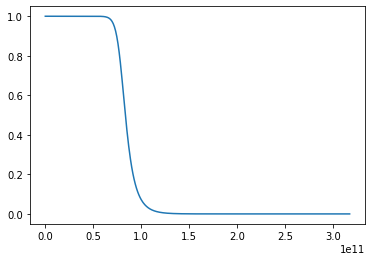

In [34]:
# Apply a filter to the reference signals
sos = signal.butter(10, .25e6, btype="low", fs=sampleRate, output="sos")

# the ones in campbell first
benRef1 = benCplx[: nS_each - gate]
benRef1_filtered = signal.sosfilt(sos, benRef1)

benRef2 = benCplx[-nS_each + gate :]
benRef2_filtered = signal.sosfilt(sos, benRef2)

# the ones in cupertino next
domRef1 = domCplx[: nS_each - gate]
domRef1_filtered = signal.sosfilt(sos, domRef1)

domRef2 = domCplx[-nS_each + gate :]
domRef2_filtered = signal.sosfilt(sos, domRef2)

w, h = signal.sosfreqz(sos,fs=sampleRate)
plt.plot((sampleRate * 0.5 / np.pi) * w, abs(h))
plt.show()

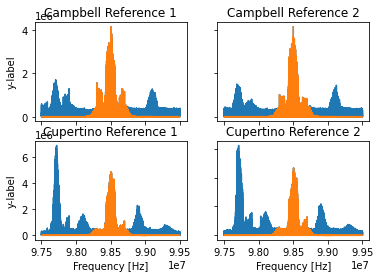

In [46]:
# plot the frequency response of the reference and then the filtered reference
fig, axs = plt.subplots(2,2)
n = len(benRef1)
yf = fft(benRef1)
yf_filt = fft(benRef1_filtered)
xf = fftfreq(n, 1/sampleRate) + refCtrFreq
axs[0,0].plot(xf,np.abs(yf))
axs[0,0].plot(xf,np.abs(yf_filt))
axs[0,0].set_title("Campbell Reference 1")

n = len(benRef2)
yf = fft(benRef2)
yf_filt = fft(benRef2_filtered)
xf = fftfreq(n, 1/sampleRate) + refCtrFreq
axs[0,1].plot(xf,np.abs(yf))
axs[0,1].plot(xf,np.abs(yf_filt))
axs[0,1].set_title("Campbell Reference 2")

n = len(domRef1)
yf = fft(domRef1)
yf_filt = fft(domRef1_filtered)
xf = fftfreq(n, 1/sampleRate) + refCtrFreq
axs[1,0].plot(xf,np.abs(yf))
axs[1,0].plot(xf,np.abs(yf_filt))
axs[1,0].set_title("Cupertino Reference 1")

n = len(domRef2)
yf = fft(domRef2)
yf_filt = fft(domRef2_filtered)
xf = fftfreq(n, 1/sampleRate) + refCtrFreq
axs[1,1].plot(xf,np.abs(yf))
axs[1,1].plot(xf,np.abs(yf_filt))
axs[1,1].set_title("Cupertino Reference 2")

for ax in axs.flat:
    ax.set(xlabel='Frequency [Hz]', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [39]:
# Correlation of the two reference signals using the differential phase method discussed here: http://www.panoradio-sdr.de/correlation-for-time-delay-analysis/
# and referencing some of the code from the matlab scripts in his library
"""
Transmitter location according to wikipedia
https://geohack.toolforge.org/geohack.php?pagename=KUFX&params=37.205_N_121.950_W_type:landmark_region:US-CA_source:FCC
repeaters here
    37.151583    -121.609917 (SE of SJ)
    37.659389    -121.933028 (NE of Fremont)
"""
# The first reference
# diff the signal
dPhase1_benGS = np.diff(np.unwrap(np.angle(benRef1_filtered)))
dPhase1_domGS = np.diff(np.unwrap(np.angle(domRef1_filtered)))

# remove the mean
dPhase1_benGS = dPhase1_benGS - np.mean(dPhase1_benGS)
dPhase1_domGS = dPhase1_domGS - np.mean(dPhase1_domGS)

# correlate the signals
dPhaseXcorr1 = signal.correlate(dPhase1_benGS, dPhase1_domGS)
dPhaseXcorr1_lags = signal.correlation_lags(len(dPhase1_benGS), len(dPhase1_domGS))
dPhaseXcorr1_max = np.max(dPhaseXcorr1)

refSig1Lag_samples = np.abs(dPhaseXcorr1_lags[np.argmax(dPhaseXcorr1)])
refSig1Lag_time = refSig1Lag_samples / sampleRate

# same process, for the second reference signal
dPhase2_benGS = np.diff(np.unwrap(np.angle(benRef2_filtered)))
dPhase2_domGS = np.diff(np.unwrap(np.angle(domRef2_filtered)))

dPhase_benGS = dPhase2_benGS - np.mean(dPhase2_benGS)
dPhase_domGS = dPhase2_domGS - np.mean(dPhase2_domGS)

dPhaseXcorr2 = signal.correlate(dPhase2_benGS, dPhase2_domGS)
dPhaseXcorr2_lags = signal.correlation_lags(len(dPhase2_benGS), len(dPhase2_domGS))
dPhaseXcorr_max2 = np.max(dPhaseXcorr1)

refSig2Lag_samples = np.abs(dPhaseXcorr2_lags[np.argmax(dPhaseXcorr2)])
refSig2Lag_time = refSig2Lag_samples / sampleRate

# print out the two lags (in units of seconds)
print(
    f"For the first reference: the lag in time is {refSig1Lag_time} and the lag in samples is {refSig1Lag_samples}"
)
print(
    f"For the second reference: the lag in time is {refSig2Lag_time} and the lag in samples is {refSig2Lag_samples}"
)


For the first reference: the lag in time is 0.3340835 and the lag in samples is 668167
For the second reference: the lag in time is 1.879027 and the lag in samples is 3758054


In [ ]:
# plot some things
# plot the original spectrum

start = int(2e6)
stop = start + 500

plt.subplot(2,1,1)
plt.plot(t[start:stop], benCplx[start:stop])
plt.plot(t[start:stop], domCplx[start:stop])
plt.xlabel("Time [seconds]")
plt.ylabel("Signal [units tbd]")
plt.title("Original Complex Signals (real parts only)")

plt.subplot(2,1,2)
plt.plot(t[start:stop], np.angle(benCplx[start:stop]))
plt.plot(t[start:stop], np.angle(domCplx[start:stop]))
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians probably]")

plt.show()

In [ ]:
# plot some things
# plot the differential phase

start = int(2e6)
stop = start + 100


plt.plot(t[start:stop], dPhase1_benGS[start:stop])
plt.plot(t[start:stop], dPhase1_domGS[start:stop])
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians probably]")
plt.title("Differential phase")
plt.show()

In [ ]:
# plot some things
# plot the spectrogram (PSD) of the references for each ground station
# note that frequency=0 corresponds to the center frequency, in this case 98.5 MHz

pxx, freqs, bins, im = plt.specgram(benCplx[: nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Campbell ground station 1st reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(domCplx[: nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Cupertino ground station 1st reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(benCplx[-nS_each + gate :], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Campbell ground station 2nd reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(domCplx[-nS_each + gate :], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Cupertino ground station 2nd reference sample frequency response")
plt.show()


In [ ]:
# plot some things
# plot the spectrogram (PSD) of the references for each ground station
# note that frequency=0 corresponds to the center frequency, in this case 98.5 MHz

pxx, freqs, bins, im = plt.specgram(benCplx[: nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, mode="phase")
plt.ylim([-np.pi,np.pi])
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians]")
plt.title("Campbell ground station 1st reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(domCplx[: nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, mode="phase")
plt.ylim([-np.pi,np.pi])
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians]")
plt.title("Cupertino ground station 1st reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(benCplx[-nS_each + gate :], NFFT=16*1024, Fs=sampleRate, noverlap=0, mode="phase")
plt.ylim([-np.pi,np.pi])
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians]")
plt.title("Campbell ground station 2nd reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(domCplx[-nS_each + gate :], NFFT=16*1024, Fs=sampleRate, noverlap=0, mode="phase")
plt.ylim([-np.pi,np.pi])
plt.xlabel("Time [seconds]")
plt.ylabel("Phase angle [radians]")
plt.title("Cupertino ground station 2nd reference sample frequency response")
plt.show()

In [ ]:
nyq = .5 * sampleRate
bandPass = [98300000 / nyq, 98800000 / nyq]
sos = signal.butter(10, bandPass, btype="bandpass", fs=sampleRate, output="sos")
benCplx_filtered = signal.sosfilt(sos, benCplx)

start = int(2e6)
stop = start + 500

plt.plot(t[start:stop], benCplx[start:stop])
plt.xlabel("Time [seconds]")
plt.ylabel("Signal [units tbd]")
plt.title("Original Complex Signals (real parts only)")
plt.show()

plt.plot(t[start:stop], benCplx_filtered[start:stop])
plt.xlabel("Time [seconds]")
plt.ylabel("Signal [units tbd]")
plt.title("Filtered Complex Signals (real parts only)")
plt.show()

pxx, freqs, bins, im = plt.specgram(benCplx[gate : nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Campbell ground station 1st reference sample frequency response")
plt.show()

pxx, freqs, bins, im = plt.specgram(benCplx_filtered[gate : nS_each - gate], NFFT=16*1024, Fs=sampleRate, noverlap=0, scale="dB")
plt.ylim([-250000,250000])
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency (deviation from 98.5 MHz) [Hz]")
plt.title("Campbell ground station 1st reference sample frequency response")
plt.show()

In [ ]:
sampleRate/2